In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
# Capture Data From Yahoo Finance

In [51]:
data = yf.download('ETH-USD')

[*********************100%%**********************]  1 of 1 completed


In [52]:
# Prepare Data

In [53]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [54]:
# Choose Number For Prediction Days
# Prediction Days = Number of days we are going to base our prediction on
# We look at the past x days (example: 60 or 90) and we look at one day into the future, so, predict 61 or 91

In [55]:
prediction_days = 60
future_day = 30

X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    X_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0]) # Day after
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [56]:
# Create Neural Network Model

In [57]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=25,
                    batch_size=32)

Epoch 1/25
68/68 [==============================] - 6s 30ms/step - loss: 0.0190
Epoch 2/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0103
Epoch 3/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0095
Epoch 4/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0092
Epoch 5/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0088
Epoch 6/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0097
Epoch 7/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0085
Epoch 8/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0086
Epoch 9/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0086
Epoch 10/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0086
Epoch 11/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0086
Epoch 12/25
68/68 [==============================] - 2s 29ms/step - loss: 0.0081
Epoch 13/25
68/68 [==================

In [58]:
start = dt.datetime(2019,1,1)
end = dt.datetime.now()

In [59]:
test_data = yf.download('ETH-USD', start, end)

[*********************100%%**********************]  1 of 1 completed


In [60]:
actual_prices = test_data['Close'].values

In [61]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [62]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

In [63]:
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [64]:
X_test = []

for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x-prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

prediction_prices = model.predict(X_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

58/58 [==============================] - 1s 11ms/step


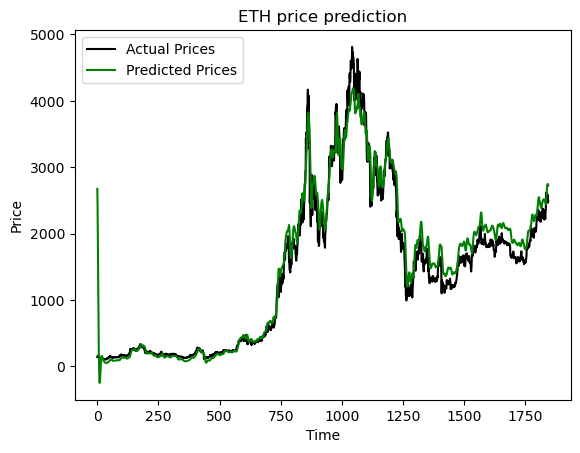

In [65]:
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left');

In [66]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [67]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

1/1 [==============================] - 1s 842ms/step


In [68]:
prediction

array([[2699.4824]], dtype=float32)